In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.functional as F

import numpy as np
from matplotlib import pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
import os

MODEL_DIR = "Non_Emb_model"
try:
    os.makedirs(MODEL_DIR)
except FileExistsError:
    print('Directories not created because they already exist')

Directories not created because they already exist


In [3]:
batch_size = 512
num_epochs = 1000
num_classes = 10  #cGAN
learning_rate = 0.00015

d_noise  = 100
d_hidden = 256

GEN_MODEL_PATH = "Non_Emb_model/Non_Emb_Generator.pth"
DIS_MODEL_PATH = "Non_Emb_model/Non_Emb_Discriminator.pth"

In [4]:
# standardization code
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean= 0.5, std=0.5)
])  


# MNIST dataset
train_set = dsets.MNIST(root='data/', train=True, transform=transform, download=True)
test_set  = dsets.MNIST(root='data/', train=False, transform=transform, download=True)


train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_set, batch_size, shuffle=True)

C:\Users\WorkStation\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
def imshow(img):
    img = (img+1)/2    
    img = img.squeeze()
    np_img = img.numpy()
    plt.imshow(np_img, cmap='gray')
    plt.show()

def imshow_grid(img):
    img = utils.make_grid(img.cpu().detach())
    img = (img+1)/2
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    
def gen_z(num_batch = 1, d_noise=100):
    return torch.randn(num_batch, d_noise, device=device)
    
def init_params(model):
    for p in model.parameters():
        if(p.dim() > 1):
            nn.init.xavier_normal_(p)
        else:
            nn.init.uniform_(p, 0.1, 0.2)

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.generator = nn.Sequential(
            nn.Linear(d_noise + num_classes, 128),
            nn.LeakyReLU(0.2),
            
            nn.Linear(128,256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            
            nn.Linear(256,512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            
            nn.Linear(512,1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),

            nn.Linear(1024, 1*28*28),
            
            nn.Tanh()
        )
        
    def forward(self, z, y):
        z_given_y = torch.cat((F.one_hot(y, num_classes=10), z), -1)
        G_z = self.generator(z_given_y)
        G_z = G_z.view(-1, 1, 28, 28)
        return G_z


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.discriminator = nn.Sequential(
            nn.Linear(num_classes + 28*28, 512),
            nn.LeakyReLU(0.2),
            
            nn.Linear(512,512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2),
            
            nn.Linear(512,512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2),
            
            nn.Linear(512,1),
            
            nn.Sigmoid()
        )
            
    def forward(self, G_z, labels):
        G_z_given_y = torch.cat((G_z.view(G_z.size(0),-1), F.one_hot(labels, num_classes=10)), -1)
        D_G_z = self.discriminator(G_z_given_y)
        return D_G_z

In [7]:
criterion = nn.BCELoss()

def train_model(G, D, _optimizer_g, _optimizer_d):
    G.train()
    D.train()

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        yb_real = torch.Tensor(x.size(0), 1).fill_(1.0).to(device) # real_label
        yb_fake = torch.Tensor(x.size(0), 1).fill_(0.0).to(device) # fake_label
        
        # ======================== train G ======================== #
        _optimizer_g.zero_grad()
        
        gen_label = torch.randint(0, num_classes,(x.size(0),)).to(device)
        z = gen_z(x.size(0), d_noise)
        p_fake = D(G(z, gen_label), gen_label)

        #loss_g = -1 * torch.log(p_fake).mean()
        loss_g = criterion(p_fake, yb_real)
        
        loss_g.backward()
        _optimizer_g.step()

        # ======================== train D ========================#
        _optimizer_d.zero_grad()

        p_real = D(x.view(-1, 28*28), y)
        
        z = gen_z(x.size(0), d_noise)
        G_z = G(z, gen_label)
        p_fake = D(G_z, gen_label)

        #loss_real = -1 * torch.log(p_real)   # -1 for gradient ascending
        #loss_fake = -1 * torch.log(1.-p_fake) # -1 for gradient ascending
        loss_real = criterion(p_real, yb_real)
        loss_fake = criterion(p_fake, yb_fake)
        loss_d = (loss_real + loss_fake).mean()

        loss_d.backward()
        _optimizer_d.step()

def evaluate_model(G, D):
    p_real, p_fake = 0., 0.

    G.eval()
    D.eval()

    for x, y in test_loader:
        x, y = x.to(device), y.to(device)

        with torch.autograd.no_grad():
            p_real += (torch.sum(D(x.view(-1, 28*28), y)).item())/len(test_set)
            
            z = gen_z(x.size(0), d_noise)
            p_fake += (torch.sum(D(G(z, y), y)).item())/len(test_set)
    return p_real, p_fake

[Epoch 100/1000] p_real: 0.8800622619628906, p_g: 0.038741019630432125


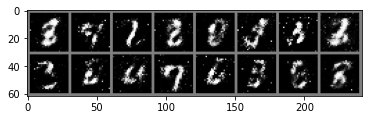

[Epoch 200/1000] p_real: 0.7161146713256835, p_g: 0.18992602195739752


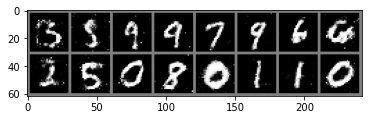

[Epoch 300/1000] p_real: 0.735377459716797, p_g: 0.3036408622741699


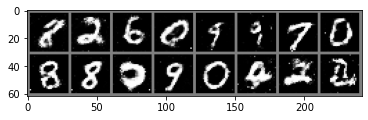

[Epoch 400/1000] p_real: 0.5569175933837891, p_g: 0.40189508819580066


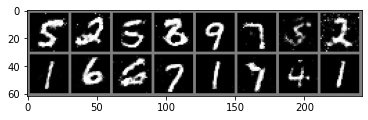

[Epoch 500/1000] p_real: 0.6534076690673828, p_g: 0.43299110412597663


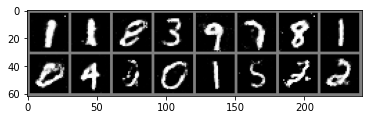

[Epoch 600/1000] p_real: 0.5692465576171875, p_g: 0.45082334442138666


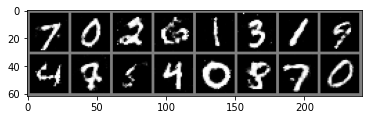

[Epoch 700/1000] p_real: 0.5071594024658203, p_g: 0.4069691223144532


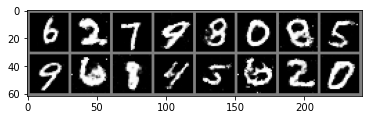

[Epoch 800/1000] p_real: 0.5200793487548828, p_g: 0.4187680313110352


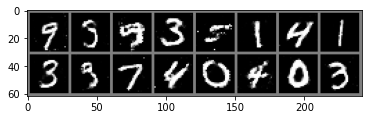

[Epoch 900/1000] p_real: 0.5385894256591798, p_g: 0.4805237365722657


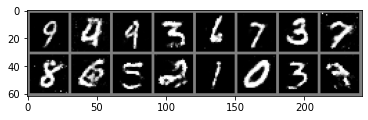

[Epoch 1000/1000] p_real: 0.5860490081787109, p_g: 0.47683688507080074


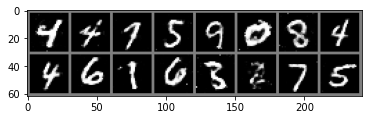

In [8]:
seed = 1228
np.random.seed(seed)
torch.manual_seed(seed)
    
generator = Generator()
discriminator = Discriminator()
generator, discriminator = generator.to(device), discriminator.to(device)
    
init_params(generator)
init_params(discriminator)
    
optimizer_g = optim.Adam(generator.parameters(), lr = learning_rate)
optimizer_d = optim.Adam(discriminator.parameters(), lr = learning_rate)
    
D_x = []
D_G_z = []
best_gap = 0.5
    
for epoch in range(num_epochs):
    train_model(generator, discriminator, optimizer_g, optimizer_d)
    p_real, p_fake = evaluate_model(generator, discriminator)
    
    D_x.append(p_real)
    D_G_z.append(p_fake)

    new_gap = (torch.abs(p_real - torch.tensor(0.5)) + torch.abs(p_fake - torch.tensor(0.5)))/2.0
    if new_gap < best_gap:
        best_gap = new_gap
        torch.save(generator.state_dict(), GEN_MODEL_PATH)
        torch.save(discriminator.state_dict(), DIS_MODEL_PATH)

    
    if((epoch+1)% 100 == 0):
        print(f'[Epoch {epoch+1}/{num_epochs}] p_real: {p_real}, p_g: {p_fake}')
            
        label = torch.randint(0, num_classes, (16,), device = device)
        imshow_grid(generator(gen_z(16), label).view(-1, 1, 28, 28))

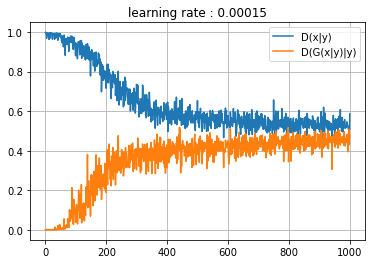

In [16]:
plt.title(f'learning rate : {learning_rate}')
plt.plot(D_x, label='D(x|y)')
plt.plot(D_G_z, label='D(G(x|y)|y)')
plt.grid()
plt.legend()
plt.show()

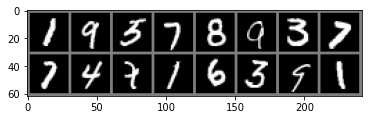

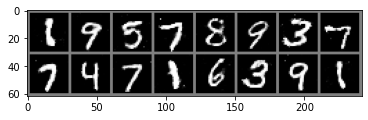

In [12]:
vis_loader = torch.utils.data.DataLoader(test_set, 16, True)
img_vis, label_vis = next(iter(vis_loader))
img_vis, label_vis = img_vis.to(device), label_vis.to(device)

imshow_grid(img_vis)
imshow_grid(generator(gen_z(16,100), label_vis).view(-1, 1, 28, 28))

**non-embedding cGAN도 conditional이 잘 동작함**

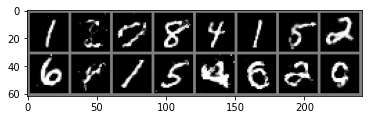

In [17]:
seed = 1228
np.random.seed(seed)
torch.manual_seed(seed)

label = torch.tensor([1, 2, 7, 8, 4, 1, 5, 2, 6, 8, 1, 5, 4, 5, 2, 9]).to(device)
imshow_grid(generator(gen_z(len(label), d_noise), label).view(-1, 1, 28, 28))